In [1]:
import matplotlib.pyplot as plt
import numpy as np

from microlensing.IPM.ipm import IPM
from microlensing.MIF.mif import MIF
from microlensing.CCF.ccf import CCF

from microlensing.Lightcurves.util import interpolated_map # for interpolating the magnification map

# Finding microimages

In [2]:
# first, let's make a magnification map to compare against later
ipm=IPM(verbose=1, kappa_tot=0.4, shear=0.4, smooth_fraction=0.5,
        num_pixels_y1=5000, num_pixels_y2=5000,
        write_stars=True)
ipm.random_seed = 1736967971 # a random seed for this specific example
ipm.run()
ipm.save()

Generating star field...
Done generating star field. Elapsed time: 0 seconds.

Creating children and sorting stars...
Done creating children and sorting stars. Elapsed time: 0.061 seconds.

Calculating multipole and local coefficients...
Done calculating multipole and local coefficients. Elapsed time: 0.064 seconds.

Shooting cells...
100 %
Done shooting cells. Elapsed time: 1.607 seconds.

Done writing parameter info to file ./ipm_parameter_info.txt
Done writing star info to file ./ipm_stars.bin


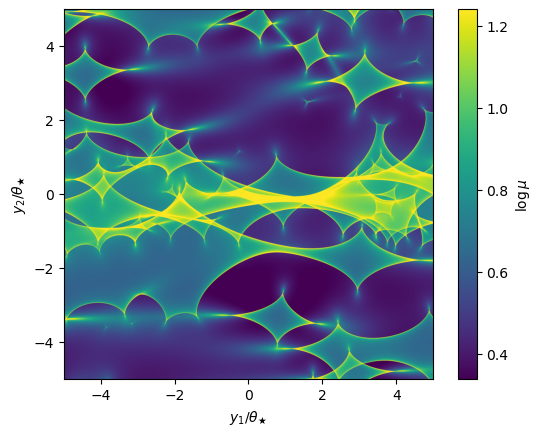

In [3]:
fig, ax = plt.subplots()
ipm.plot(ax)
plt.show()

In [4]:
# we'll want to plot the critical curves later
ccf = CCF(verbose=0, kappa_tot=ipm.kappa_tot, shear=ipm.shear, 
          starfile=f'{ipm.outfile_prefix}ipm_stars.bin',
          num_phi=200)
ccf.run()

In [5]:
# now, let's find the microimages
mif = MIF(verbose=1, kappa_tot=ipm.kappa_tot, shear=ipm.shear, 
          starfile=f'{ipm.outfile_prefix}ipm_stars.bin',
          y1=-2, y2=1, # source position to find the microimages of. notice on the magnification map that this is inside multiple caustics
          v1=0, v2=1, # velocity (just to get a direction, magnitude not important) of the source trajectory that passes through the provided position
          write_image_lines=True)

In [6]:
mif.run()

Creating children and sorting stars...
Done creating children and sorting stars. Elapsed time: 0.066 seconds.

Calculating multipole and local coefficients...
Done calculating multipole and local coefficients. Elapsed time: 0.07 seconds.

Finding images...
Done finding images.

Finding point images...
Done finding point images.



In [7]:
# to demonstrate that the images found are indeed unique
print(mif.images.shape)
print(np.unique(np.round(mif.images, 7), axis=0).shape)

(477, 2)
(477, 2)


# Plotting

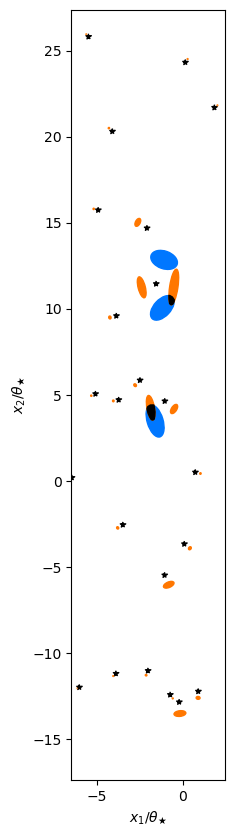

In [8]:
# plotting just the microimages and the stars
# as expected, since our macroimage is a minimum, and we are inside multiple caustics, there are extra microminima (blue)
# while there are orange microsaddles near the stars
fig, ax = plt.subplots(figsize=(10,10))
mif.stars.plot(ax, s=0.03)
mif.plot_images(ax)

# set the plot range to the region containing most of the microimage flux
ax.set_xlim(mif.c99[0])
ax.set_ylim(mif.c99[1])
ax.set_aspect(1)

plt.show()

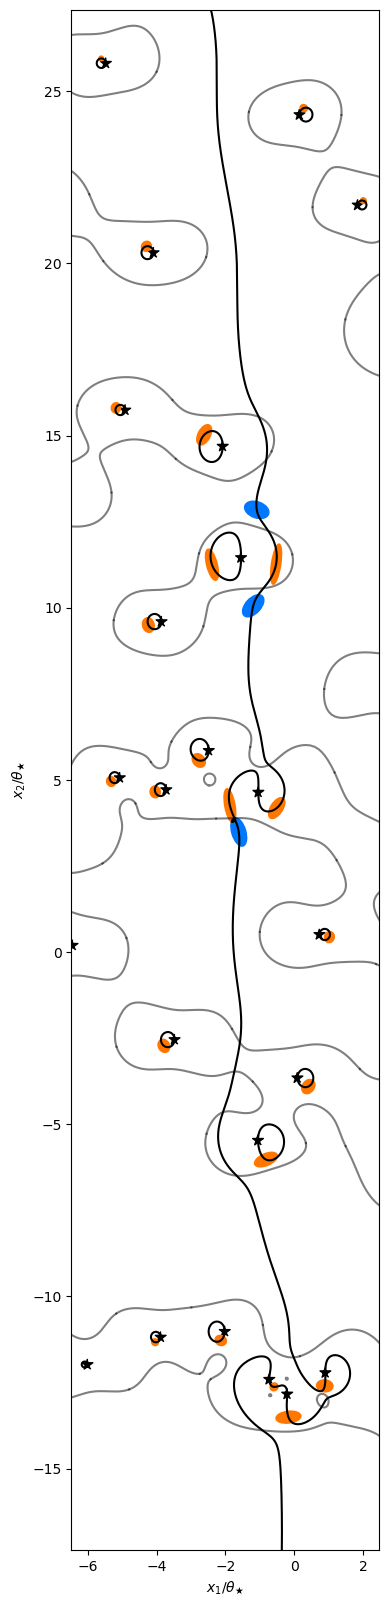

In [9]:
# we can plot the image line as well. notice also the loops that pass through stars
fig, ax = plt.subplots(figsize=(20,20))

ccf.plot_critical_curves(ax, alpha=0.5)

mif.plot_image_lines(ax)
mif.stars.plot(ax, s=0.03)
mif.plot_images(ax, log_area=True) # log area scaling so we can see more of the microimages

# set the plot range to the region containing most of the microimage flux
ax.set_xlim(mif.c99[0])
ax.set_ylim(mif.c99[1])
ax.set_aspect(1)

plt.show()

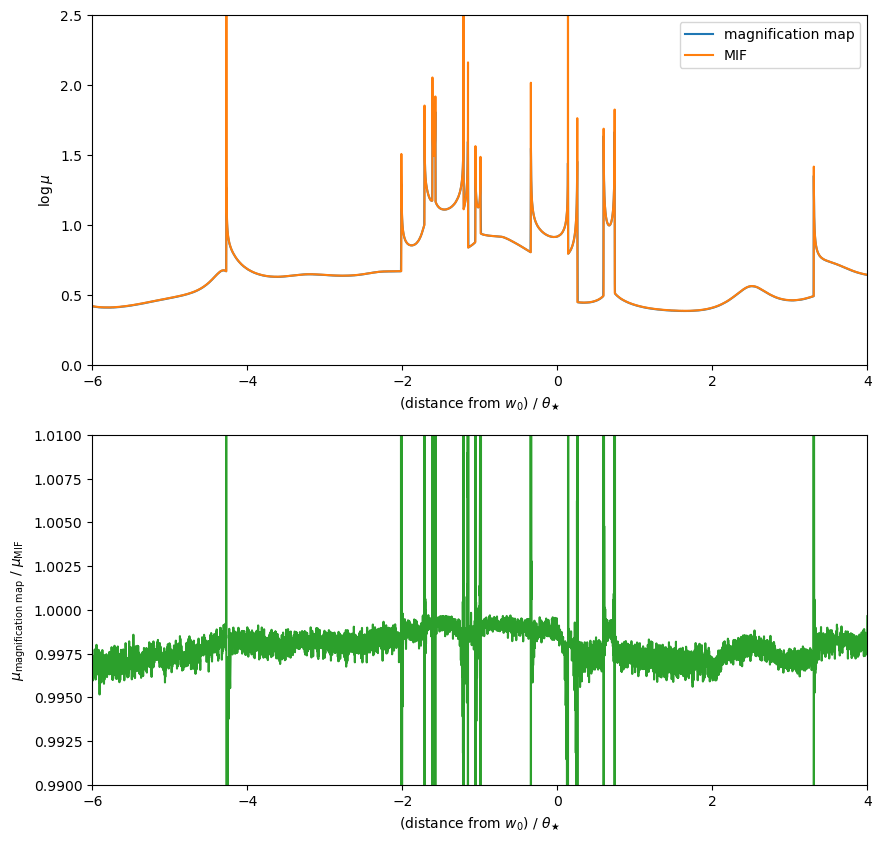

In [10]:
# plot the light curve
fig, axes = plt.subplots(2,1, figsize=(10,10))

ax = axes[0]

# interpolate the magnification map (log mu, since that's the default plotting for MIF)
mu_interp = interpolated_map(np.log10(ipm.magnifications), ipm.center, ipm.half_length, ipm.num_pixels)
# calculate positions along the track
x = mif.w0 + mif.v / np.linalg.norm(mif.v) * mif.distances[:,None]
# and get the magnifications
try:
    y = mu_interp(x).get() # in case cupy is installed, need to get the values from the gpu
except AttributeError:
    y = mu_interp(x) # otherwise just using numpy

# this will show just one curve...
ax.plot(mif.distances, y, label='magnification map')
mif.plot_lightcurve(ax, label='MIF')
ax.set_xlim([-6,4])
ax.set_ylim([0,2.5])
ax.legend()

# ...because this plot of the errors shows us that the magnifications from
# the magnification map and the microimage finder are the same, to within
# better than 1%, with the large deviations only occuring at the caustics
# where the magnification map resolution is not sufficient
ax = axes[1]
ax.plot(mif.distances, 10**y / mif.magnifications, color='C2')
ax.set_xlim([-6,4])
ax.set_ylim([0.99,1.01])
ax.set_xlabel(axes[0].get_xlabel())
ax.set_ylabel('$\\mu_\\text{magnification map}$ / $\\mu_\\text{MIF}$')

plt.show()